In [19]:
import rasterio

# Replace with your HGT file path
hgt_file = "N00W079.hgt"

with rasterio.open(hgt_file) as dataset:
    elevation = dataset.read(1)  # Read the first band (elevation data)
    print(elevation)

[[  35   40   53 ... 2149 2201 2170]
 [  36   22   34 ... 2216 2248 2216]
 [  46   34   46 ... 2269 2292 2254]
 ...
 [ 760  768  773 ... 4648 4699 4743]
 [ 767  771  774 ... 4606 4676 4710]
 [ 775  778  784 ... 4589 4654 4687]]


In [20]:
elevation.shape

(1201, 1201)

In [21]:
import numpy as np

# Get the affine transform from the dataset
with rasterio.open(hgt_file) as ds:
    transform = ds.transform

height, width = elevation.shape

# Create meshgrid of pixel coordinates
cols, rows = np.meshgrid(np.arange(width), np.arange(height))

# Convert pixel coordinates to geographic coordinates
lon, lat = rasterio.transform.xy(transform, rows, cols, offset="center")
lon = np.array(lon)
lat = np.array(lat)

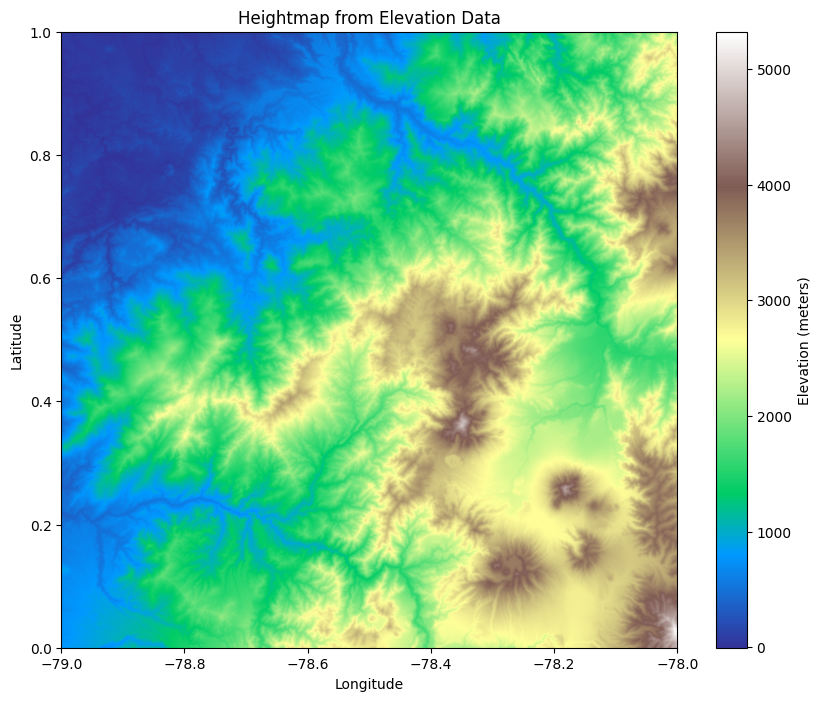

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(
    elevation,
    cmap="terrain",
    extent=[lon.min(), lon.max(), lat.min(), lat.max()],
    origin="upper",
)
plt.colorbar(label="Elevation (meters)")
plt.title("Heightmap from Elevation Data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [23]:
import glob
from rasterio.merge import merge

# Find all HGT files in the current directory
hgt_files = sorted(glob.glob("*.hgt"))

# Read all HGT files and store their elevation arrays
elevation_arrays = []
transforms = []

for file in hgt_files:
    with rasterio.open(file) as src:
        elevation_arrays.append(src.read(1))
        transforms.append(src.transform)

# Example: Stack arrays along a new axis (for demonstration)
# You may want to mosaic or merge them spatially using rasterio.merge

src_files_to_mosaic = [rasterio.open(fp) for fp in hgt_files]
mosaic, out_trans = merge(src_files_to_mosaic)

# Close all opened files
for src in src_files_to_mosaic:
    src.close()

print("Mosaic shape:", mosaic.shape)

Mosaic shape: (1, 14401, 12001)


In [ ]:
mosaic.shape

(1, 14401, 12001)

In [ ]:
2

2

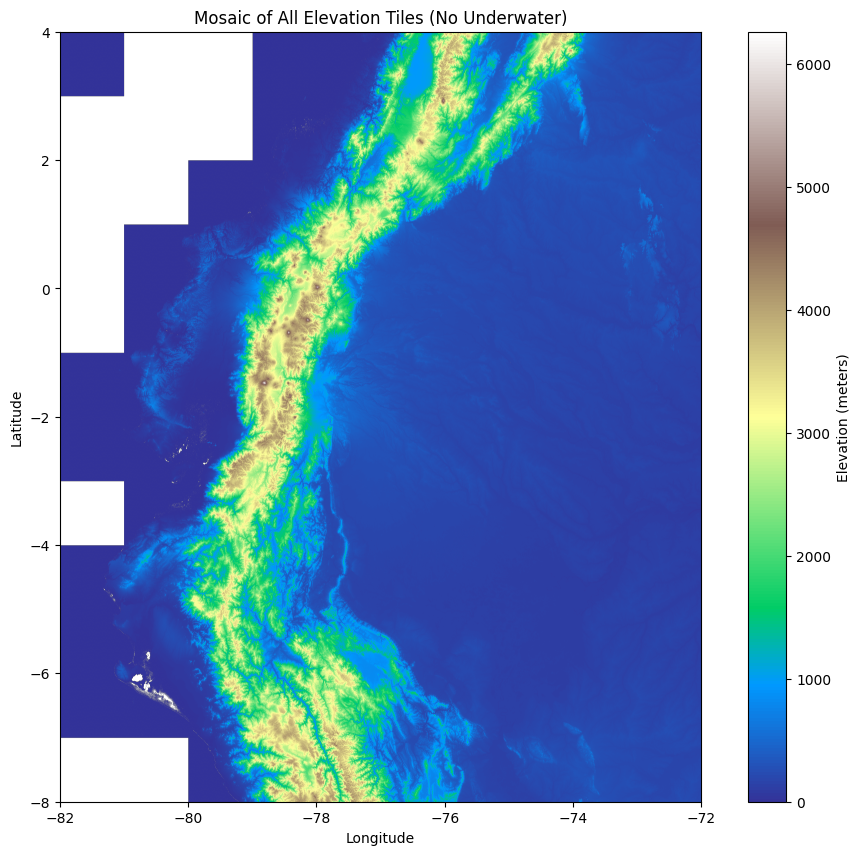

In [24]:
# Mask underwater (negative elevation) values
mosaic_masked = np.ma.masked_less(mosaic[0], 0)

plt.figure(figsize=(12, 10))
plt.imshow(
    mosaic_masked,
    cmap="terrain",
    extent=[
        out_trans.c,
        out_trans.c + out_trans.a * mosaic.shape[2],
        out_trans.f + out_trans.e * mosaic.shape[1],
        out_trans.f,
    ],
    origin="upper",
)
plt.colorbar(label="Elevation (meters)")
plt.title("Mosaic of All Elevation Tiles (No Underwater)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
Y.shape

(9601, 12001)

In [30]:
mosaic_masked

masked_array(
  data=[[0, 0, 0, ..., 185, 185, 186],
        [0, 0, 0, ..., 186, 187, 190],
        [0, 0, 0, ..., 184, 185, 190],
        ...,
        [--, --, --, ..., 233, 223, 224],
        [--, --, --, ..., 228, 225, 230],
        [--, --, --, ..., 230, 228, 238]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=np.int64(999999),
  dtype=int16)

In [25]:
# Create a dictionary mapping (latitude, longitude) to elevation from the mosaic
# Use a stride to avoid excessive memory usage if needed

lat_flat = Y.flatten()
lon_flat = X.flatten()
elev_flat = mosaic_masked.flatten()

# Only include valid (unmasked) points
valid = ~mosaic_masked.mask.flatten()
lat_valid = lat_flat[valid]
lon_valid = lon_flat[valid]
elev_valid = elev_flat[valid]

# Create the dictionary
latlon_to_elev = {
    (float(lat), float(lon)): float(elev)
    for lat, lon, elev in zip(lat_valid, lon_valid, elev_valid)
}

IndexError: boolean index did not match indexed array along axis 0; size of axis is 115221601 but size of corresponding boolean axis is 172826401

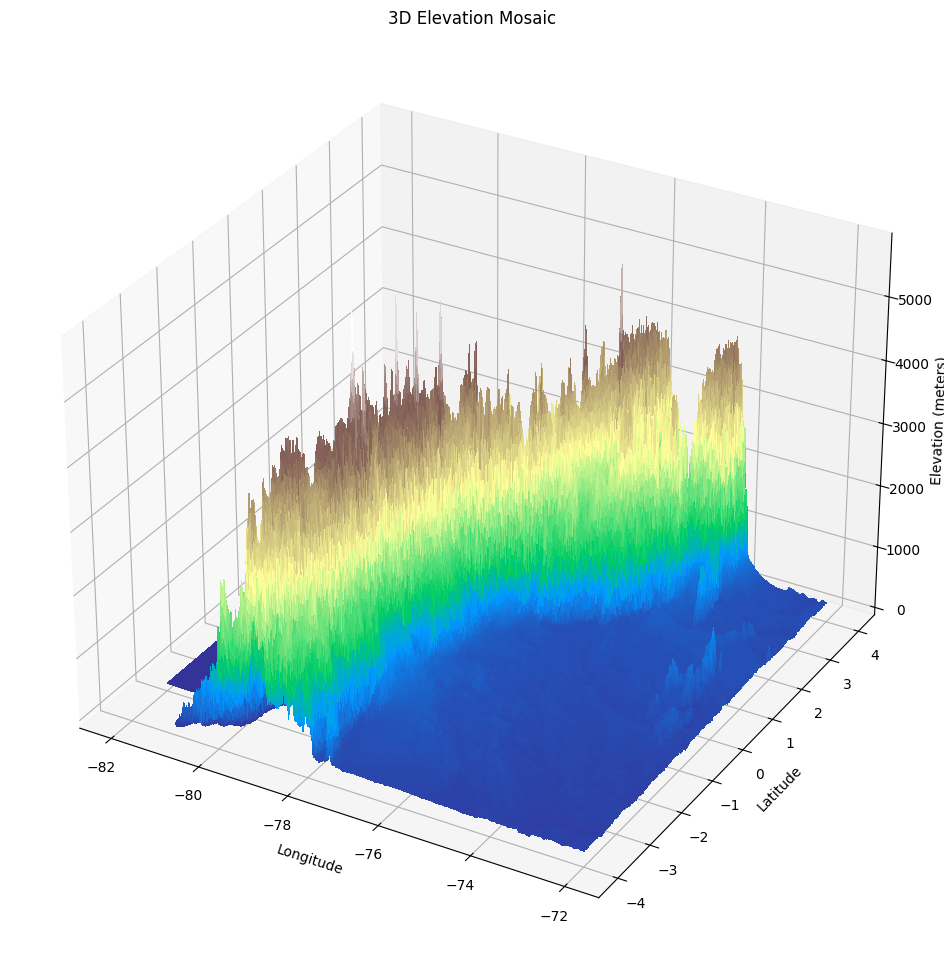

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Create meshgrid for the mosaic
mosaic_lon = np.linspace(
    out_trans.c, out_trans.c + out_trans.a * mosaic.shape[2], mosaic.shape[2]
)
mosaic_lat = np.linspace(
    out_trans.f, out_trans.f + out_trans.e * mosaic.shape[1], mosaic.shape[1]
)
X, Y = np.meshgrid(mosaic_lon, mosaic_lat)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection="3d")

# Downsample for performance if needed
stride = max(1, mosaic.shape[1] // 500)
ax.plot_surface(
    X[::stride, ::stride],
    Y[::stride, ::stride],
    mosaic_masked[::stride, ::stride],
    cmap="terrain",
    linewidth=0,
    antialiased=False,
    rstride=1,
    cstride=1,
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Elevation (meters)")
ax.set_title("3D Elevation Mosaic")
plt.show()